In [1]:
from tkinter import N
from joblib import PrintTime
import pvlib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import daytime
import Funciones  
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error

# Locación a Evaluar
Para esta investigación se decidió reducir las posibles a distintas partes de Colombia. se evaluará el efecto que tendrían distintos paneles 

In [2]:
tz = 'America/Bogota'
#El paso
lat, lon = 9.789103, -73.722451 # 9.789103, -73.722451 Esta es las coordenas
altitude = 50

#
location = pvlib.location.Location(lat, lon, tz, altitude)

api_key = 'rMYPYAhkiXjb9WUAjQVU728EI59XhF2TeY9ml5cz'
email = 'da.parral@uniandes.edu.co'
tmy, header = pvlib.iotools.get_psm3(lat, lon, api_key, email, 
                                            names='2020')


In [3]:
tmy_columns_rename = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'temp_air', 'Dew Point', 'dhi', 'dni', 'ghi', 'albedo', 'Pressure', 'Wind Direction', 'wind_speed']
tmy.columns = tmy_columns_rename


In [4]:
solpos = pvlib.solarposition.get_solarposition(tmy.index, lat, lon)
# remove nighttime
tmy = tmy.loc[solpos['apparent_elevation'] > 0, :]
solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]

# Funciones
Se reutilizaron las funciones del código base de planta


In [5]:
def irrad_total_bifacial(front,back, bifaciality):
    try:
        x=back.mul(bifaciality)
        irrad=front.add(x)
        return(irrad)
    except: 
        print("irrad_total_bifacial failed")

In [6]:
def dc_production(effective_irradiance, module_temperature,module,system):
    #Single Diode Parameters
    IL, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_cec(effective_irradiance,
                                                      module_temperature,
                                                      module['alpha_sc'],
                                                      module['a_ref'],
                                                      module['I_L_ref'],
                                                      module['I_o_ref'],
                                                      module['R_sh_ref'],
                                                      module['R_s'],
                                                      module['Adjust'],
                                                      EgRef=1.121,
                                                      dEgdT=-0.0002677)

    curve_info = pvlib.pvsystem.singlediode(photocurrent=IL,
                                      saturation_current=I0,
                                      resistance_series=Rs,
                                      resistance_shunt=Rsh,
                                      nNsVth=nNsVth,
                                      ivcurve_pnts=100,
                                      method='lambertw')

    #Scalating CEC et. al. Single Diode Results
    data_i_sc = pd.Series(curve_info['i_sc'])
    data_v_oc = pd.Series(curve_info['v_oc'])
    data_i_mp = pd.Series(curve_info['i_mp'])
    data_v_mp = pd.Series(curve_info['v_mp'])
    data_p_mp = pd.Series(curve_info['p_mp'])
    data_i_x = pd.Series(curve_info['i_x'])
    data_i_xx = pd.Series(curve_info['i_xx'])

    results_general = pd.DataFrame({'i_sc': data_i_sc, 
                                    'v_oc': data_v_oc,
                                    'i_mp': data_i_mp, 
                                    'v_mp': data_v_mp, 
                                    'p_mp': data_p_mp, 
                                    'i_x': data_i_x,
                                    'i_xx': data_i_xx})

    #DC Dataframe
    datetime_index = effective_irradiance.index

    dc = system.scale_voltage_current_power(results_general)
    dc = dc.set_index(datetime_index)

    
    
    return dc

In [7]:
def losses(dc, loss):

    losses = loss/100 #According to the paper Performance Parameters for Grid-Connected PV Systems by NREL

    #Losses System A
    dc['i_mp'] = dc['i_mp'] - dc['i_mp']*losses
    dc['p_mp'] = dc['p_mp'] - dc['p_mp']*losses


    return dc

In [8]:
def pvlib_ac_power(dc,inverter, total_inversores=1):
    ac= pvlib.inverter.sandia(dc['v_mp'], dc['p_mp'], inverter)
    
    
    pvlib_ac = ac * total_inversores
    
    pvlib_ac.loc[pvlib_ac < 0] = 0
    pvlib_ac.fillna(value=0, inplace=True)
    
    return pvlib_ac

In [9]:
def pvwatts_ac(dc,dc_0,inv=1):
    ac=pvlib.inverter.pvwatts(dc,dc_0)
    pv_ac=ac*inv
    pv_ac.loc[pv_ac < 0] = 0
    pv_ac.fillna(value=0, inplace=True)

# Especificaciones

In [10]:
modules_database = 'CECMOD'
modules = pvlib.pvsystem.retrieve_sam(modules_database)

modules.to_csv("DB.csv")
module=modules.LG_Electronics_Inc__LG370N2T_A4
print(module)

Technology            Mono-c-Si
Bifacial                      1
STC                      370.76
PTC                       340.6
A_c                        1.95
Length                     1.99
Width                      0.98
N_s                          72
I_sc_ref                   9.78
V_oc_ref                   48.8
I_mp_ref                    9.2
V_mp_ref                   40.3
alpha_sc               0.002934
beta_oc                -0.13176
T_NOCT                     46.8
a_ref                  1.829992
I_L_ref                9.790371
I_o_ref                     0.0
R_s                    0.311815
R_sh_ref             294.038879
Adjust                 8.790824
gamma_r                   -0.37
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: LG_Electronics_Inc__LG370N2T_A4, dtype: object


In [11]:
inverters_database = 'CECInverter'
inverters = pvlib.pvsystem.retrieve_sam(inverters_database)
inverterx = inverters.Power_Electronics__FS1275CU15__690V_
print(inverterx)

Vac                          690
Pso                 12941.101563
Paco                   1389080.0
Pdco                   1421523.0
Vdco                      1030.0
C0                          -0.0
C1                      0.000007
C2                     -0.000112
C3                      0.000557
Pnt                      416.724
Vdcmax                    1200.0
Idcmax               1380.119417
Mppt_low                   976.0
Mppt_high                 1200.0
CEC_Date              10/15/2018
CEC_Type     Utility Interactive
Name: Power_Electronics__FS1275CU15__690V_, dtype: object


In [12]:
mps_A = 25 #Modules Per String
spi_A = 210 #Strings Per Inverter


system_A = pvlib.pvsystem.PVSystem(module_parameters=module, 
                    inverter_parameters=inverterx, 
                    modules_per_string=mps_A, 
                    strings_per_inverter=spi_A)


# Evaluación de sensibilidad del sitema


## Parametros 

In [13]:
#Parametros
"Parámetros iniciales para el sistema"
height=2
albedo=0.5
gcr=0.5
Backtrack=True
axis_azimuth=180
axis_tilt=0
max_angle=45
pvrow_width=0.98
bifacialty=0.90
#Fixed 
fixed_azimuth=180
fixed_tilt=10

Puntos a evaluar para hacer análisis de sensibilidad


In [14]:
#[altura,gcr,albedo]
Puntos=[[1,0.5,0.2],
        [1,0.5,0.5],
        [1,0.5,0.7],
        [1,0.75,0.2],
        [1,0.75,0.5],
        [1,0.75,0.7],
        [1,1,0.2],
        [1,1,0.5],
        [1,1,0.7],
        [2,0.5,0.2],
        [2,0.5,0.5],
        [2,0.5,0.7],
        [2,0.75,0.2],
        [2,0.75,0.5],
        [2,0.75,0.7],
        [2,1,0.2],
        [2,1,0.5],
        [2,1,0.7],
        [3,0.5,0.2],
        [3,0.5,0.5],
        [3,0.5,0.7],
        [3,0.75,0.2],
        [3,0.75,0.5],
        [3,0.75,0.7],
        [3,1,0.2],
        [3,1,0.5],
        [3,1,0.7],]
Puntos_sol=[]


In [15]:
"Definición sistema de seguimiento"
tracker = pvlib.tracking.singleaxis(apparent_zenith=solpos.apparent_zenith, 
                                    apparent_azimuth=solpos.azimuth, 
                                    axis_tilt=axis_tilt,
                                    axis_azimuth=axis_azimuth, #Heading south
                                    max_angle=max_angle, 
                                    backtrack=Backtrack, 
                                    gcr=gcr)
tracker = tracker.fillna(0)
"Definición sistema Fijo"
fixed_tilt_series=pd.DataFrame(index=tracker.index,data=fixed_tilt*np.ones(len(tracker.index)),columns=["Val"])
fixed_azimuth_series=pd.DataFrame(index=tracker.index,data=fixed_azimuth*np.ones(len(tracker.index)),columns=["Val"])

In [16]:
"cálculo preeliminar de la radiación para el calculo de temperatura"
poa_front,poa_back,poa_frontabsorb,poa_backabsorb = pvlib.bifacial.pvfactors_timeseries(surface_tilt=tracker.surface_tilt, 
                                                                        surface_azimuth=tracker.surface_azimuth, 
                                                                        solar_zenith=solpos.zenith, 
                                                                        solar_azimuth=solpos.azimuth, 
                                                                        axis_azimuth=axis_azimuth,
                                                                        timestamps=tmy.index,
                                                                        dni=tmy.dni, 
                                                                        dhi=tmy.dhi,
                                                                        gcr=gcr,
                                                                        pvrow_height=height,
                                                                        pvrow_width=2*pvrow_width,
                                                                        #albedo=surface_albedo,
                                                                        albedo=albedo, 
                                                                        n_pvrows=3,
                                                                        index_observed_pvrow=1,
                                                                        rho_back_pvrow=0.05,
                                                                        rho_front_pvrow=0.03,
                                                                        horizon_band_angle=15)

c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\geometry\base.py:349: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.list_surfaces = list_surfaces
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\geometry\base.py:350: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.shaded = self._get_shading(shaded)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\geometry\base.py:351: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.is_collinear = is_collinear(list_surfaces)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\geometry\base.py:352: ShapelyDeprecationWarning: Setting custom a

In [17]:
poa_front_f,poa_back_f,poa_frontabsorb_f,poa_backabsorb_f = pvlib.bifacial.pvfactors_timeseries(surface_tilt=fixed_tilt_series.Val, 
                                                                        surface_azimuth=fixed_azimuth_series.Val, 
                                                                        solar_zenith=solpos.zenith, 
                                                                        solar_azimuth=solpos.azimuth, 
                                                                        axis_azimuth=axis_azimuth,
                                                                        timestamps=tmy.index,
                                                                        dni=tmy.dni, 
                                                                        dhi=tmy.dhi,
                                                                        gcr=gcr,
                                                                        pvrow_height=height,
                                                                        pvrow_width=2*pvrow_width,
                                                                        #albedo=surface_albedo,
                                                                        albedo=albedo, 
                                                                        n_pvrows=3,
                                                                        index_observed_pvrow=1,
                                                                        rho_back_pvrow=0.05,
                                                                        rho_front_pvrow=0.03,
                                                                        horizon_band_angle=15)

c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\v

In [18]:
temp_cell = pvlib.temperature.sapm_module(poa_global=poa_front, 
                                        temp_air=tmy.temp_air, 
                                        wind_speed=tmy.wind_speed, 
                                        a=-3.47, 
                                        b=-0.0594)
temp_cell_fixed= pvlib.temperature.sapm_module(poa_global=poa_front, 
                                        temp_air=tmy.temp_air, 
                                        wind_speed=tmy.wind_speed, 
                                        a=-3.47, 
                                        b=-0.0594)

## Código iterativo Bifacial
Para evaluar distintos valores de ML variar el parámetro M_m

In [19]:
M_m=1
"Variables para guardar datos y poder analizarlos luego"
poa_back_mat=[]
irrads=[]
dcs=[]
dcs_mono=[]
dcmeans=[]
dcmeans_mono=[]
ac=[]
acprod=[]
acprodt=[]
acprodp=[]
ac_mono=[]
acprod_mono=[]
acprod_monot=[]
acprod_monop=[]
BGs=[]
prods=[]
Puntos_sol=[]
prodsi=[]
hs=[]
gcrs=[]
n=0
for Punto in Puntos:
    
    h=Punto[0]
    gcr=Punto[1]
    tracker = pvlib.tracking.singleaxis(apparent_zenith=solpos.apparent_zenith, 
                                    apparent_azimuth=solpos.azimuth, 
                                    axis_tilt=axis_tilt,
                                    axis_azimuth=axis_azimuth, #Heading south
                                    max_angle=max_angle, 
                                    backtrack=Backtrack, 
                                    gcr=gcr)
    tracker = tracker.fillna(0)

    albedo=Punto[2]
    Area_p=1.95*mps_A*spi_A
    Area_t=Area_p/gcr
    poa_fronti,poa_backi,poa_frontabsorbi,poa_backabsorbi = pvlib.bifacial.pvfactors_timeseries(surface_tilt=tracker.surface_tilt, 
                                                                        surface_azimuth=tracker.surface_azimuth, 
                                                                        solar_zenith=solpos.zenith, 
                                                                        solar_azimuth=solpos.azimuth, 
                                                                        axis_azimuth=axis_azimuth,
                                                                        timestamps=tmy.index,
                                                                        dni=tmy.dni, 
                                                                        dhi=tmy.dhi,
                                                                        gcr=gcr,
                                                                        pvrow_height=h,
                                                                        pvrow_width=2*pvrow_width,
                                                                        #albedo=surface_albedo,
                                                                        albedo=albedo, 
                                                                        n_pvrows=3,
                                                                        index_observed_pvrow=1,
                                                                        rho_back_pvrow=0.05,
                                                                        rho_front_pvrow=0.03,
                                                                        horizon_band_angle=15)


    poa_back_mat.append(poa_backabsorbi)
    irradi=irrad_total_bifacial(poa_frontabsorbi,
                     poa_backabsorbi,bifacialty)

    irrads.append(irradi)
    #DC
    dc=dc_production(irradi,temp_cell,module,system_A)
    dc=losses(dc,16.3)
    dc_mono=dc_production(poa_frontabsorbi,temp_cell,module,system_A)
    dc_mono=losses(dc_mono,16.3)
    dcs.append(dc)
    dcs_mono.append(dc_mono)

    #AC
    aci=pvlib_ac_power(dc,inverterx)
    ac.append(aci)
    aci_mono=pvlib_ac_power(dc_mono,inverterx)
    ac_mono.append(aci)
    acprodi=aci.sum()
    acprodi_mono=aci_mono.sum()

    #AC LCOE
    acprodit=acprodi/Area_t
    acprodip=acprodi/Area_p
    acprodit_mono=acprodi_mono/Area_t
    acprodip_mono=acprodi_mono/Area_p

    acprod.append(acprodit)
    acprod_mono.append(acprodi_mono)
    BG=(acprodi/acprodi_mono)-1
    LCOE_star_i=(M_m+(1/gcr))/(acprodip)
    BGs.append(BG)
    Punto.append(acprodi)
    Punto.append(BG)
    Punto.append(LCOE_star_i)
    Punto.append(acprodit)
    Punto.append(acprodip)
    Puntos_sol.append(Punto)
    hs.append(h)
    gcrs.append(gcr)
    prods.append(acprodi)
    
    
    


c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\v

In [20]:
"Para poder realizar los analisis de sensibilidad se exportaron los dato a un csv"
import csv
with open("MinitabsFinal.csv","w") as f:
    write=csv.writer(f)
    write.writerows(Puntos_sol)
Puntos_sol=[]
Punto=[]

## Evaluación de GCR y ML
Para evaluar a más detalle el gcr y el ML se evaluaron más puntos y se compararon los efectos


In [21]:
evalGCR=[
        [1,1],
        [1,0.9],
        [1,0.8],
        [1,0.7],
        [1,0.6],
        [1,0.5],
        [1,0.4],
        [1,0.3],
        [1,0.2],
        [1,0.1],
        [2.5,1],
        [2.5,0.9],
        [2.5,0.8],
        [2.5,0.7],
        [2.5,0.6],
        [2.5,0.5],
        [2.5,0.4],
        [2.5,0.3],
        [2.5,0.2],
        [2.5,0.1],
        [5,1],
        [5,0.9],
        [5,0.8],
        [5,0.7],
        [5,0.6],
        [5,0.5],
        [5,0.4],
        [5,0.3],
        [5,0.2],
        [5,0.1],
        [7.5,1],
        [7.5,0.9],
        [7.5,0.8],
        [7.5,0.7],
        [7.5,0.6],
        [7.5,0.5],
        [7.5,0.4],
        [7.5,0.3],
        [7.5,0.2],
        [7.5,0.1],

]
dimension=10
gcrs_eval=[1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
pitch=(2*pvrow_width*np.ones(10))/gcrs_eval
pitch=pitch.tolist()
M_ms=[1,2.5,5,7.5]


## Código 

In [22]:
h=2 #m
albedo=0.25
acgcr=[]
acgcri=[]
acgcrmono=[]
acgcrmonoi=[]
BGgcr=[]
BGgcri=[]
LCOESgcr=[]
LCOESigcr=[]
LCOESgcr_mono=[]
LCOESigcr_mono=[]


for Point in evalGCR:
    
    M_m=Point[0]
    gcr=Point[1]
    tracker = pvlib.tracking.singleaxis(apparent_zenith=solpos.apparent_zenith, 
                                    apparent_azimuth=solpos.azimuth, 
                                    axis_tilt=axis_tilt,
                                    axis_azimuth=axis_azimuth, #Heading south
                                    max_angle=max_angle, 
                                    backtrack=Backtrack, 
                                    gcr=gcr)
    tracker = tracker.fillna(0)
    Area_p=1.95
    Area_t=Area_p/gcr
    poa_fronti,poa_backi,poa_frontabsorbi,poa_backabsorbi = pvlib.bifacial.pvfactors_timeseries(surface_tilt=tracker.surface_tilt, 
                                                                        surface_azimuth=tracker.surface_azimuth, 
                                                                        solar_zenith=solpos.zenith, 
                                                                        solar_azimuth=solpos.azimuth, 
                                                                        axis_azimuth=axis_azimuth,
                                                                        timestamps=tmy.index,
                                                                        dni=tmy.dni, 
                                                                        dhi=tmy.dhi,
                                                                        gcr=gcr,
                                                                        pvrow_height=h,
                                                                        pvrow_width=2*pvrow_width,
                                                                        #albedo=surface_albedo,
                                                                        albedo=albedo, 
                                                                        n_pvrows=3,
                                                                        index_observed_pvrow=1,
                                                                        rho_back_pvrow=0.05,
                                                                        rho_front_pvrow=0.03,
                                                                        horizon_band_angle=15)
    

    
    irradi=irrad_total_bifacial(poa_frontabsorbi,
                     poa_backabsorbi,bifacialty)
    
    dc=dc_production(irradi,temp_cell,module,system_A)
    dc=losses(dc,16.3)
    dc_mono=dc_production(poa_frontabsorbi,temp_cell,module,system_A)
    dc_mono=losses(dc_mono,16.3)
    aci=pvlib_ac_power(dc,inverterx)
    aci_mono=pvlib_ac_power(dc_mono,inverterx)
    acprodi=aci.sum()
    acprodi_mono=aci_mono.sum()
    acprodit=acprodi/Area_t     #Energía por unidad de Area de terreno
    acprodip=acprodi/Area_p     #Energía por unidad de Area de terreno
    acprodit_mono=acprodi_mono/Area_t
    acprodip_mono=acprodi_mono/Area_p
    BG=(acprodi/acprodi_mono)-1
    LCOE_star_i=(M_m+(1/gcr))/(acprodip)
    LCOE_star_i_mono=((M_m)+(1/gcr))/(acprodip_mono)
    LCOESigcr.append(LCOE_star_i)
    if len(LCOESigcr)==dimension:
        LCOESgcr.append(LCOESigcr)
        LCOESigcr=[]
    BGgcri.append(BG)
    if len(BGgcri)==dimension:
        BGgcr.append(BGgcri)
        BGgcri=[]
    LCOESigcr_mono.append(LCOE_star_i_mono)
    
    if len(LCOESigcr_mono)==dimension:
        LCOESgcr_mono.append(LCOESigcr_mono)
        LCOESigcr_mono=[]
    acgcri.append(acprodi/1000000000)
    if len(acgcri)==dimension:
        acgcr.append(acgcri)
        acgcri=[]
    acgcrmonoi.append(acprodi_mono/1000000000)
    if len(acgcrmonoi)==dimension:
        acgcrmono.append(acgcrmonoi)
        acgcrmonoi=[]
    
    

c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\geometry\pvground.py:121: RuntimeWarning: divide by zero encountered in true_divide
  dx = (y1s_pvrow - y_ground) / np.tan(rotation_vec)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\irradiance\models.py:890: RuntimeWarning: divide by zero encountered in true_divide
  (high_pt_right.y - ts_point_coords.y)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\irradiance\models.py:879: RuntimeWarning: divide by zero encountered in true_divide
  (high_pt_left.y - ts_point_coords.y)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: invalid value e

## Gráficas

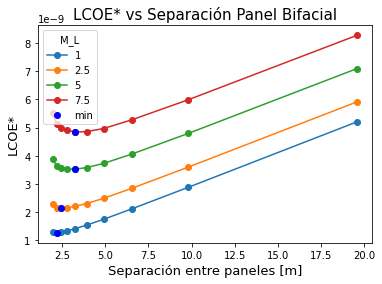

In [33]:


for LCOE in LCOESgcr:
    
    plt.plot(pitch,LCOE,marker="o")
Mins=[]
for LCOE in LCOESgcr:
    Minx=min(LCOE)
    Mins.append(Minx)
    LCOES_min=LCOE.index(min(LCOE))
    plt.plot(pitch[LCOES_min],LCOE[LCOES_min],"bo")
title='LCOE* vs Separación Panel Bifacial'
ylabel='LCOE*'
xlabel='Separación entre paneles [m]'
plt.title(title, fontsize=15)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel, fontsize=13)
#plt.xlim([1,0.1])
M_x=M_ms.copy()
M_x.append("min")
plt.legend(M_x,title="M_L",loc="upper left")
#for LCOEs in LCOESgcr_mono:
#    plt.plot(gcrs_eval,LCOEs,marker="*")

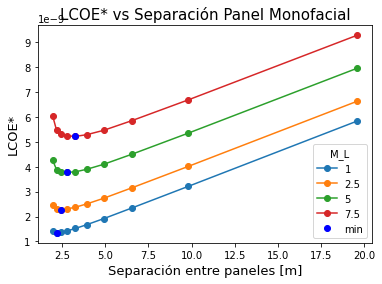

In [37]:
for LCOEs in LCOESgcr_mono:
    plt.plot(pitch,LCOEs,marker="o")
mins=[]
for LCOEs in LCOESgcr_mono:
    minx=min(LCOEs)
    mins.append(minx)
    LCOEs_min=LCOEs.index(min(LCOEs))
    plt.plot(pitch[LCOEs_min],LCOEs[LCOEs_min],"bo")
title='LCOE* vs Separación Panel Monofacial'
ylabel='LCOE*'
xlabel='Separación entre paneles [m]'
plt.title(title, fontsize=15)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel, fontsize=13)
#plt.xlim([1,0.1])
plt.legend(M_x,title="M_L")


In [ ]:
with open("Mins.csv","w") as f:
    write=csv.writer(f)
    write.writerow(Mins)
    write.writerow(mins)

Text(0.5, 0, 'Separación entre filas [m]')

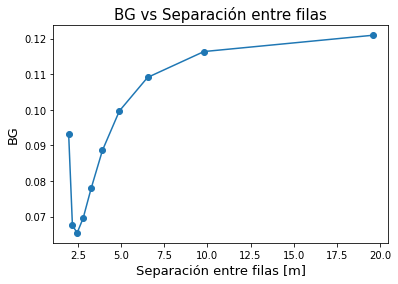

In [25]:
plt.plot(pitch,BGgcr[1],marker="o")

title='BG vs Separación entre filas'
ylabel='BG'
xlabel='Separación entre filas [m]'
plt.title(title, fontsize=15)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel, fontsize=13)



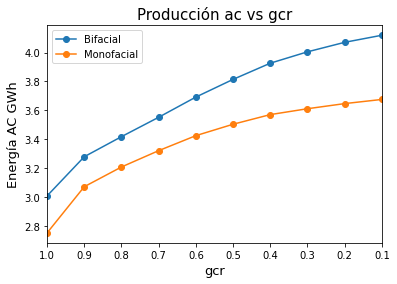

In [26]:
plt.plot(gcrs_eval,acgcr[1],marker="o")
plt.plot(gcrs_eval,acgcrmono[1],marker="o")
title='Producción ac vs gcr'
ylabel='Energía AC GWh'
xlabel='gcr'
plt.title(title, fontsize=15)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel, fontsize=13)
plt.xlim([1,0.1])
plt.legend(["Bifacial","Monofacial"])




# Efecto de la úbicación de la planta

Se realizó una evaluación de 3 ubicaciones 

In [27]:
api_key = 'rMYPYAhkiXjb9WUAjQVU728EI59XhF2TeY9ml5cz'
email = 'da.parral@uniandes.edu.co'
latlon = [[9.789103, -73.722451,50 ],[ 5.7683773, -73.109763,2525],[11.390897,-72.292316,52]]
NSDB=[]
for location in latlon:
    tz = 'America/Bogota'
    lat=location[0]
    
    lon=location[1]
    altitud=location[2]
    location = pvlib.location.Location(lat, lon, tz, altitud)
    tmyi, header = pvlib.iotools.get_psm3(lat, lon, api_key, email, 
                                            names='2020')

                                            
    tmy_columns_rename = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'temp_air', 'Dew Point', 'dhi', 'dni', 'ghi', 'albedo', 'Pressure', 'Wind Direction', 'wind_speed']
    tmyi.columns = tmy_columns_rename
    
    solposi = pvlib.solarposition.get_solarposition(tmyi.index, lat, lon)
    dni_tot=tmyi.dni.sum()
    dhi_tot=tmyi.dhi.sum()
    M_rad=dhi_tot/dni_tot
    print(M_rad)
    # remove nighttime
    tmyi = tmyi.loc[solposi['apparent_elevation'] > 0, :]
    solposi = solposi.loc[solposi['apparent_elevation'] > 0, :]
    DB=[tmyi,solposi,lat,lon]
    NSDB.append(DB)
    

0.42405559833000667
0.548965408153461
0.34155915358782873


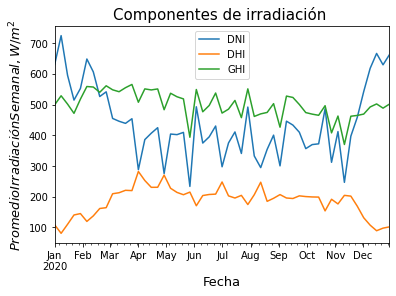

c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\v

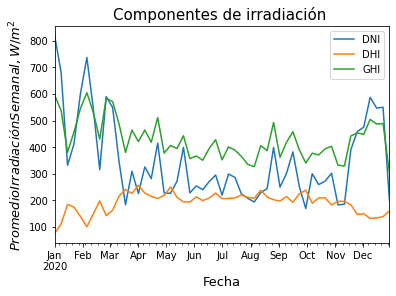

c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\v

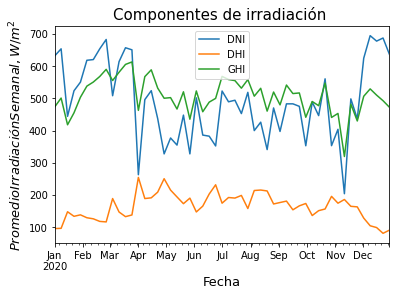

c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\v

In [28]:
"Variables oara simulación"
BG_many=[]
AC_many=[]
BG_DC=[]
BGT_S=[]
BGF_S=[]
TGB_S=[]
TGM_S=[]
TG_S=[]
Acprod=[]
Acprod_mono=[]
Acprod_fixed=[]
Acprod_monofixed=[]

for loc in NSDB:
    tmyi=loc[0]
    solposi=loc[1]
    lat=loc[2]
    tmyg=tmyi.dni.resample("7D").mean().plot()
    tmyg=tmyi.dhi.resample("7D").mean().plot()
    tmyg=tmyi.ghi.resample("7D").mean().plot()
    title='Componentes de irradiación '
    ylabel='$PromedioIrradiaciónSemanal, W/m^2$'
    xlabel='Fecha'
    plt.title(title, fontsize=15)
    plt.ylabel(ylabel, fontsize=13)
    plt.xlabel(xlabel, fontsize=13)
    plt.legend(['DNI','DHI',"GHI"])
    plt.show()
    #Parametros
    height=2
    albedo=0.25
    gcr=0.6
    Backtrack=True
    axis_azimuth=180
    axis_tilt=0
    max_angle=45
    pvrow_width=0.98
    bifacialty=0.90
    #Fixed 
    fixed_azimuth=180
    fixed_tilt=lat+5
    trackeri = pvlib.tracking.singleaxis(apparent_zenith=solposi.apparent_zenith, 
                                    apparent_azimuth=solposi.azimuth, 
                                    axis_tilt=0,
                                    axis_azimuth=180, #Heading south
                                    max_angle=45, 
                                    backtrack=True, 
                                    gcr=0.25)

    trackeri = trackeri.fillna(0)

    airmass = location.get_airmass(times=tmyi.index, 
                               solar_position=solposi, 
                               model='kastenyoung1989')

    airmass.head()

    poa_front,poa_back,poa_frontabsorb,poa_backabsorb = pvlib.bifacial.pvfactors_timeseries(surface_tilt=trackeri.surface_tilt, 
                                                                        surface_azimuth=trackeri.surface_azimuth, 
                                                                        solar_zenith=solposi.zenith, 
                                                                        solar_azimuth=solposi.azimuth, 
                                                                        axis_azimuth=axis_azimuth,
                                                                        timestamps=tmyi.index,
                                                                        dni=tmyi.dni, 
                                                                        dhi=tmyi.dhi,
                                                                        gcr=gcr,
                                                                        pvrow_height=height,
                                                                        pvrow_width=2*pvrow_width,
                                                                        #albedo=surface_albedo,
                                                                        albedo=albedo, 
                                                                        n_pvrows=3,
                                                                        index_observed_pvrow=1,
                                                                        rho_back_pvrow=0.05,
                                                                        rho_front_pvrow=0.03,
                                                                        horizon_band_angle=15)
    fixed_tilt_series=pd.DataFrame(index=tmyi.index,data=fixed_tilt*np.ones(len(tmyi.index)),columns=["Val"])
    fixed_azimuth_series=pd.DataFrame(index=tmyi.index,data=fixed_azimuth*np.ones(len(tmyi.index)),columns=["Val"])
    poa_frontf,poa_backf,poa_frontabsorbf,poa_backabsorbf = pvlib.bifacial.pvfactors_timeseries(surface_tilt=fixed_tilt_series.Val, 
                                                                        surface_azimuth=fixed_azimuth_series.Val, 
                                                                        solar_zenith=solposi.zenith, 
                                                                        solar_azimuth=solposi.azimuth, 
                                                                        axis_azimuth=axis_azimuth,
                                                                        timestamps=tmyi.index,
                                                                        dni=tmyi.dni, 
                                                                        dhi=tmyi.dhi,
                                                                        gcr=gcr,
                                                                        pvrow_height=height,
                                                                        pvrow_width=2*pvrow_width,
                                                                        #albedo=surface_albedo,
                                                                        albedo=albedo, 
                                                                        n_pvrows=3,
                                                                        index_observed_pvrow=1,
                                                                        rho_back_pvrow=0.05,
                                                                        rho_front_pvrow=0.03,
                                                                        horizon_band_angle=15) 
                                                                            
    temp_cell = pvlib.temperature.sapm_module(poa_global=poa_front, 
                                        temp_air=tmyi.temp_air, 
                                        wind_speed=tmyi.wind_speed, 
                                        a=-3.47, 
                                        b=-0.0594)
    temp_cell_fixed= pvlib.temperature.sapm_module(poa_global=poa_frontf, 
                                        temp_air=tmyi.temp_air, 
                                        wind_speed=tmyi.wind_speed, 
                                        a=-3.47, 
                                        b=-0.0594)
                                        
    irradi=irrad_total_bifacial(poa_frontabsorb,
                     poa_backabsorb,bifacialty)
    irradif=irrad_total_bifacial(poa_frontabsorbf,
                     poa_backabsorbf,bifacialty)


    dc=dc_production(irradi,temp_cell,module,system_A)
    dc=losses(dc,16.3)   
    dc_mono=dc_production(poa_frontabsorb,temp_cell,module,system_A)
    dc_mono=losses(dc_mono,16.3)
    dc_fixed=dc_production(irradif,temp_cell_fixed,module,system_A)
    dc_fixed=losses(dc_fixed,16.3)
    dc_monofixed=dc_production(poa_frontabsorbf,temp_cell_fixed,module,system_A)
    dc_monofixed=losses(dc_monofixed,16.3)
    ac=pvlib_ac_power(dc,inverterx)
    ac_mono=pvlib_ac_power(dc_mono,inverterx)
    ac_fixed=pvlib_ac_power(dc_fixed,inverterx)
    ac_monofixed=pvlib_ac_power(dc_monofixed,inverterx)
    acprod=ac.sum()
    Acprod.append(acprod/1000000000)
    acprod_mono=ac_mono.sum()
    Acprod_mono.append(acprod_mono/1000000000)
    acprod_fixed=ac_fixed.sum()
    Acprod_fixed.append(acprod_fixed/1000000000)
    acprod_monofixed=ac_monofixed.sum()
    Acprod_monofixed.append(acprod_monofixed/1000000000)
    
    AC_X=[ac,ac_mono,ac_fixed,ac_monofixed]
    BGT=(acprod/acprod_mono)-1                  #Ganancia por panel bifacial sistema de seguimiento
    BGT_S.append(BGT*100)                   
    TGB=(acprod/acprod_fixed)-1                 #Ganancia por sistema de seguimiento panel bifacial
    TGB_S.append(TGB*100)
    TGM=(acprod_mono/acprod_monofixed)-1        #Ganancia por sistema de seguimiento panel monofacial
    TGM_S.append(TGM*100)
    BGF=(acprod_fixed/acprod_monofixed)-1       #Ganancia por panel bifacial sistema fijo
    BGF_S.append(BGF*100)
    TG=(acprod/acprod_monofixed)-1              #Ganancia total del sistema
    TG_S.append(TG*100)
    BG_x=[BGT,BGF,TGB,TGM,TG]
    BG_many.append(BG_x)
    
    
    

    

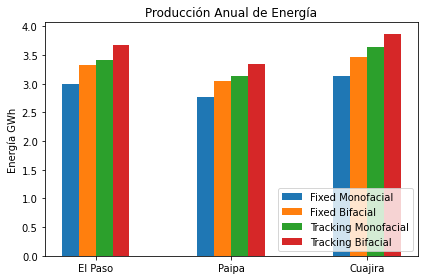

In [29]:
labels=["El Paso","Paipa","Cuajira"]

fig, ax = plt.subplots()
x=np.arange(3)
width=0.25
rects1 = ax.bar(x - width*3/4, Acprod_monofixed, width/2, label='Fixed')
rects2 = ax.bar(x - width/4, Acprod_fixed, width/2, label='Fixed Bifacial')
rects3 = ax.bar(x + width/4, Acprod_mono, width/2, label='Tracker')
rects4 = ax.bar(x + width*3/4, Acprod, width/2, label='Tracker Bifacial')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Energía GWh')
ax.set_title('Producción Anual de Energía')
ax.set_xticks(x, labels)
ax.legend(["Fixed Monofacial","Fixed Bifacial","Tracking Monofacial", "Tracking Bifacial"],loc="lower right")


fig.tight_layout()

plt.show()

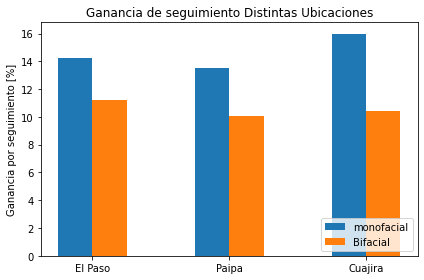

In [30]:
labels=["El Paso","Paipa","Cuajira"]

fig, ax = plt.subplots()
x=np.arange(3)
width=0.25
rects1 = ax.bar(x - width/2, TGM_S, width, label='Tracker')
rects2 = ax.bar(x + width/2, BGF_S, width, label='Fixed')


ax.set_ylabel('Ganancia por seguimiento [%]')
ax.set_title('Ganancia de seguimiento Distintas Ubicaciones')
ax.set_xticks(x, labels)
ax.legend(["monofacial","Bifacial"],loc="lower right")


fig.tight_layout()

plt.show()